# GrIS ablation zone melt SEB causality

Author: Ziqi Yin

Last modified: 2025 Aug 7

Description: comparing causal graphs from RACMO, MAR, and CESM2 LENS2 during the historical period (1940-1969), and comparing LENS2 graph during the historical period with future scenario (2071-2100)

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

import sys
home_dir = '/glade/work/ziqiyin/'
sys.path.insert(0, home_dir)
from copy import deepcopy

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp

from tigramite.models import LinearMediation, Models
from tigramite.causal_effects import CausalEffects

from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb

import cartopy
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.collections import PolyCollection
from collections import Counter, defaultdict

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/ziqiyin/conda-envs/my-npl-202306a/share/proj failed


In [3]:
# Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

## Read data

### Causal graph

In [4]:
val_matrix_RACMO_his_alphas = []
graph_RACMO_his_alphas = []
link_width_RACMO_his_alphas = []

val_matrix_MAR_his_alphas = []
graph_MAR_his_alphas = []
link_width_MAR_his_alphas = []

val_matrix_LENS2_his_alphas = []
graph_LENS2_his_alphas = []
link_width_LENS2_his_alphas = []

val_matrix_LENS2_end_alphas = []
graph_LENS2_end_alphas = []
link_width_LENS2_end_alphas = []

In [6]:
## Set parameters
max_lag = 12
pc_alphas = [0.05, 0.1, None]

In [12]:
for pc_alpha in pc_alphas:

    # RACMO
    data_dir = home_dir+'2023-GrIS-melt-causality/data/RACMO/graph_pcmciplus_bootstrap_melt_RACMO_SEB_RACMO_noGHF_realJJA_GrIS_ablation_seasonality_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(max_lag)+'_alpha'+str(pc_alpha)+'_clean_forplot.npz'
    data = np.load(data_dir, allow_pickle=True)
    val_matrix_RACMO_his_alphas.append(data['val_matrix'])
    graph_RACMO_his_alphas.append(data['graph'])
    link_width_RACMO_his_alphas.append(data['link_width'])
    var_names = data['var_names'].tolist()

    # MAR
    data_dir = home_dir+'2023-GrIS-melt-causality/data/MAR/graph_pcmciplus_bootstrap_melt_MAR_SEB_MAR_noGHF_realJJA_GrIS_ablation_RACMOmask_1940_1969_conservative_nofdrc_robustparcorr_maxtau'+str(max_lag)+'_alpha'+str(pc_alpha)+'_clean_forplot.npz'
    data = np.load(data_dir, allow_pickle=True)
    val_matrix_MAR_his_alphas.append(data['val_matrix'])
    graph_MAR_his_alphas.append(data['graph'])
    link_width_MAR_his_alphas.append(data['link_width'])

    # LENS2
    data_dir = home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BHIST_realJJA_GrIS_ablation_noseasonality_LENS2_1940_1969_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig_forplot.npz'
    data = np.load(data_dir, allow_pickle=True)
    val_matrix_LENS2_his_alphas.append(data['val_matrix'])
    graph_LENS2_his_alphas.append(data['graph'])
    link_width_LENS2_his_alphas.append(data['link_width'])

    data_dir = home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig_forplot.npz'
    data = np.load(data_dir, allow_pickle=True)
    val_matrix_LENS2_end_alphas.append(data['val_matrix'])
    graph_LENS2_end_alphas.append(data['graph'])
    link_width_LENS2_end_alphas.append(data['link_width'])


## Plot

In [16]:
def tp_plot_graph(val_matrix, graph, link_width, show_colorbar, i):

    tp.plot_graph(
        val_matrix=val_matrix,
        graph=graph,
        var_names=var_names,
        link_width=link_width,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        node_size=0.4,
        node_label_size=14,
        node_ticks=0.5,
        edge_ticks=0.5,
        link_label_fontsize=14,
        arrow_linewidth=10.0,
        #lagged_links=True  # This setting allows multiple links for different lags to be displayed
        show_colorbar=show_colorbar,
        fig_ax=(fig, axs[i])
    )

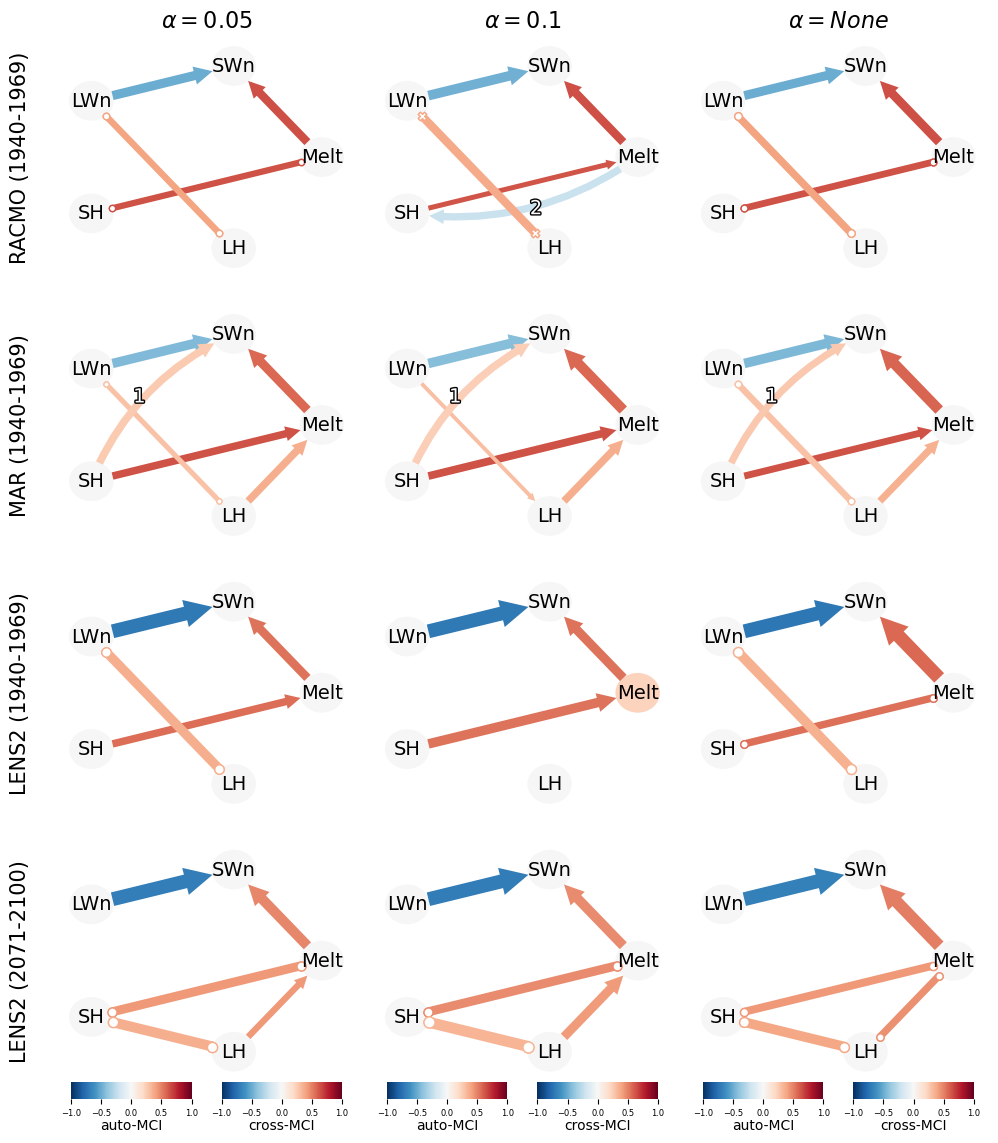

In [27]:
##
fig, axs = plt.subplots(4, 3, figsize=(10, 11.5))
axs = axs.flatten()  # Flatten to easily index subplots

for n in range(3):
    tp_plot_graph(val_matrix_RACMO_his_alphas[n], graph_RACMO_his_alphas[n], link_width_RACMO_his_alphas[n], False, n)
    tp_plot_graph(val_matrix_MAR_his_alphas[n], graph_MAR_his_alphas[n], link_width_MAR_his_alphas[n], False, n+3)
    tp_plot_graph(val_matrix_LENS2_his_alphas[n], graph_LENS2_his_alphas[n], link_width_LENS2_his_alphas[n], False, n+6)
    tp_plot_graph(val_matrix_LENS2_end_alphas[n], graph_LENS2_end_alphas[n], link_width_LENS2_end_alphas[n], True, n+9)


# Add significance level
size_title = 16
axs[0].set_title("$\\alpha = 0.05$", fontsize=size_title)
axs[1].set_title("$\\alpha = 0.1$", fontsize=size_title)
axs[2].set_title("$\\alpha = None$", fontsize=size_title)

# Add model name
axs[0].text(-0.12, 0.5, "RACMO (1940-1969)", rotation=90,
           transform=axs[0].transAxes,
           ha='center', va='center',
           fontsize=size_title-1)
axs[3].text(-0.12, 0.5, "MAR (1940-1969)", rotation=90,
           transform=axs[3].transAxes,
           ha='center', va='center',
           fontsize=size_title-1)
axs[6].text(-0.12, 0.5, "LENS2 (1940-1969)", rotation=90,
           transform=axs[6].transAxes,
           ha='center', va='center',
           fontsize=size_title-1)
axs[9].text(-0.12, 0.5, "LENS2 (2071-2100)", rotation=90,
           transform=axs[9].transAxes,
           ha='center', va='center',
           fontsize=size_title-1)

plt.tight_layout()
plot_dir = home_dir+'2023-GrIS-melt-causality/manuscript/'
plt.savefig(plot_dir+'figS3_causal_graph_monthly_1940_1969_conservative_nofdrc_robustparcorr_taumax12_alphas_nomask.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)